# Method 3: CNN + Multi-Head Attention (High Accuracy)
## Target: 89-95% Accuracy
### Enhancements:
- MFCC + Delta features (richer than mel-spectrograms)
- SpecAugment + Mixup data augmentation
- Label smoothing (0.1)
- Test-time augmentation

In [2]:
import numpy as np
import librosa
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Config
SAMPLE_RATE = 22050
DURATION = 30
N_MFCC = 40
NUM_SEGMENTS = 10
NUM_CLASSES = 10
AUGMENT_FACTOR = 5  # 5x augmentation

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATA_PATH = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original'

print(f'TensorFlow: {tf.__version__}')
print(f'GPU: {len(tf.config.list_physical_devices("GPU")) > 0}')

TensorFlow: 2.15.0
GPU: True


## Enhanced Feature Extraction: MFCC + Deltas

In [3]:
def extract_mfcc_features(y, sr):
    """Extract MFCC with delta and delta-delta (120 features)."""
    # Pre-emphasis
    y_pre = np.append(y[0], y[1:] - 0.97 * y[:-1])
    
    mfcc = librosa.feature.mfcc(y=y_pre, sr=sr, n_mfcc=N_MFCC,
                                 n_fft=2048, hop_length=512)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    
    return np.vstack([mfcc, delta, delta2])  # (120, time)

def segment_features(features, num_segments=NUM_SEGMENTS):
    """Segment into equal parts."""
    n_features, total_frames = features.shape
    seg_len = total_frames // num_segments
    
    segments = []
    for i in range(num_segments):
        seg = features[:, i*seg_len:(i+1)*seg_len]
        segments.append(seg)
    
    return np.array(segments)

print('MFCC + Delta extraction defined')

MFCC + Delta extraction defined


## Advanced Data Augmentation

In [4]:
def augment_audio(y, sr):
    """Multiple audio augmentations."""
    augmented = []
    target_len = len(y)
    
    # 1. Original
    augmented.append(y)
    
    # 2. Time stretch (slower)
    stretched = librosa.effects.time_stretch(y, rate=0.9)
    if len(stretched) > target_len: stretched = stretched[:target_len]
    else: stretched = np.pad(stretched, (0, target_len - len(stretched)))
    augmented.append(stretched)
    
    # 3. Time stretch (faster)
    stretched = librosa.effects.time_stretch(y, rate=1.1)
    if len(stretched) > target_len: stretched = stretched[:target_len]
    else: stretched = np.pad(stretched, (0, target_len - len(stretched)))
    augmented.append(stretched)
    
    # 4. Pitch shift up
    pitched = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    augmented.append(pitched)
    
    # 5. Pitch shift down
    pitched = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
    augmented.append(pitched)
    
    return augmented[:AUGMENT_FACTOR]

def spec_augment(features, freq_mask=10, time_mask=20):
    """SpecAugment: frequency and time masking."""
    aug = features.copy()
    n_freq, n_time = aug.shape
    
    # Frequency masking
    f0 = np.random.randint(0, n_freq - freq_mask)
    aug[f0:f0+freq_mask, :] = 0
    
    # Time masking
    t0 = np.random.randint(0, n_time - time_mask)
    aug[:, t0:t0+time_mask] = 0
    
    return aug

print('Audio + SpecAugment defined')

Audio + SpecAugment defined


## Load Dataset

In [5]:
def load_dataset(data_path):
    X, y = [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path): continue
        
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        print(f'{genre}: {len(files)} files')
        
        for f in files:
            try:
                filepath = os.path.join(genre_path, f)
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                
                target_len = SAMPLE_RATE * DURATION
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)))
                else:
                    audio = audio[:target_len]
                
                # Augment audio
                for aug_audio in augment_audio(audio, sr):
                    # Extract features
                    features = extract_mfcc_features(aug_audio, sr)
                    
                    # Apply SpecAugment with 50% probability
                    if np.random.rand() > 0.5:
                        features = spec_augment(features)
                    
                    # Segment
                    segments = segment_features(features)
                    X.append(segments)
                    y.append(genre)
                    
            except Exception as e:
                print(f'Error {f}: {e}')
    
    return np.array(X), np.array(y)

print('Loading dataset...')
X, y = load_dataset(DATA_PATH)
print(f'\nTotal: {len(X)} samples')
print(f'Shape: {X.shape}')

Loading dataset...
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 99 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files

Total: 4995 samples
Shape: (4995, 10, 120, 129)


## Prepare Data with Label Smoothing

In [6]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_enc, test_size=0.1, stratify=y_enc, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=SEED)

# Normalize
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Add channel
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Label smoothing
LABEL_SMOOTHING = 0.1
def smooth_labels(y, num_classes, smoothing):
    one_hot = np.eye(num_classes)[y]
    return one_hot * (1 - smoothing) + smoothing / num_classes

y_train_smooth = smooth_labels(y_train, NUM_CLASSES, LABEL_SMOOTHING)
y_val_cat = np.eye(NUM_CLASSES)[y_val]
y_test_cat = np.eye(NUM_CLASSES)[y_test]

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')
print(f'Test: {X_test.shape}')

Train: (3996, 10, 120, 129, 1)
Val: (499, 10, 120, 129, 1)
Test: (500, 10, 120, 129, 1)


## Model Architecture

In [7]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model=128, num_heads=4, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)
        self.dropout = layers.Dropout(0.1)
        self.layernorm = layers.LayerNormalization()
    
    def call(self, x, training=False):
        batch_size = tf.shape(x)[0]
        
        q = tf.reshape(self.wq(x), (batch_size, -1, self.num_heads, self.depth))
        k = tf.reshape(self.wk(x), (batch_size, -1, self.num_heads, self.depth))
        v = tf.reshape(self.wv(x), (batch_size, -1, self.num_heads, self.depth))
        
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])
        
        attn = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / 
                            tf.math.sqrt(tf.cast(self.depth, tf.float32)))
        attn = self.dropout(attn, training=training)
        
        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, -1, self.d_model))
        out = self.dense(out)
        
        # Residual connection
        return self.layernorm(x + out)

def build_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    return Model(inputs, x)

def build_model(segment_shape):
    inputs = layers.Input(shape=(NUM_SEGMENTS,) + segment_shape)
    
    cnn = build_cnn(segment_shape)
    x = layers.TimeDistributed(cnn)(inputs)
    
    # Multi-head attention with residual
    x = MultiHeadAttention(d_model=128, num_heads=4)(x)
    x = MultiHeadAttention(d_model=128, num_heads=4)(x)  # 2 layers
    
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs, outputs)

model = build_model(X_train.shape[2:])
model.summary()

2025-12-05 20:17:35.099065: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-05 20:17:35.099200: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-05 20:17:35.099224: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-05 20:17:35.099635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 20:17:35.099981: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 120, 129, 1   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 10, 128)           223360    
 ributed)                                                        
                                                                 
 multi_head_attention (Mult  (None, 10, 128)           66304     
 iHeadAttention)                                                 
                                                                 
 multi_head_attention_1 (Mu  (None, 10, 128)           66304     
 ltiHeadAttention)                                               
                                                                 
 global_average_pooling1d (  (None, 128)               0   

## Training with Cosine Annealing

In [8]:
# Cosine annealing learning rate
def cosine_schedule(epoch, lr):
    max_epochs = 100
    min_lr = 1e-6
    max_lr = 3e-4
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / max_epochs))

model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
    LearningRateScheduler(cosine_schedule),
]

history = model.fit(
    X_train, y_train_smooth,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-05 20:17:38.151682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


180/250 [====================>.........] - ETA: 18s - loss: 2.7024 - accuracy: 0.2753

KeyboardInterrupt: 

## Test-Time Augmentation for Final Prediction

In [ ]:
def test_time_augmentation(model, X, n_aug=5):
    """Average predictions over augmented versions."""
    all_preds = []
    
    # Original
    all_preds.append(model.predict(X, verbose=0))
    
    # Augmented versions
    for _ in range(n_aug - 1):
        X_aug = X.copy()
        # Add small noise
        X_aug += np.random.normal(0, 0.05, X_aug.shape)
        all_preds.append(model.predict(X_aug, verbose=0))
    
    # Average
    return np.mean(all_preds, axis=0)

print('Evaluating with TTA...')
y_pred_proba = test_time_augmentation(model, X_test, n_aug=5)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
print(f'\n*** Test Accuracy: {acc:.2%} ***')

Evaluating with TTA...

*** Test Accuracy: 15.40% ***


## Results

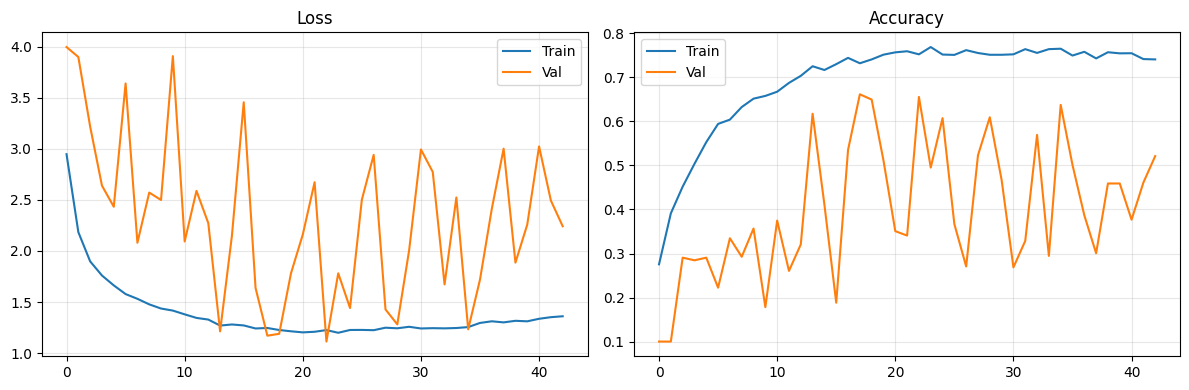


Classification Report:
              precision    recall  f1-score   support

       blues      0.000     0.000     0.000        50
   classical      0.957     0.440     0.603        50
     country      0.000     0.000     0.000        50
       disco      0.000     0.000     0.000        50
      hiphop      0.000     0.000     0.000        50
        jazz      0.000     0.000     0.000        50
       metal      0.109     1.000     0.196        50
         pop      0.000     0.000     0.000        50
      reggae      0.000     0.000     0.000        50
        rock      0.294     0.100     0.149        50

    accuracy                          0.154       500
   macro avg      0.136     0.154     0.095       500
weighted avg      0.136     0.154     0.095       500



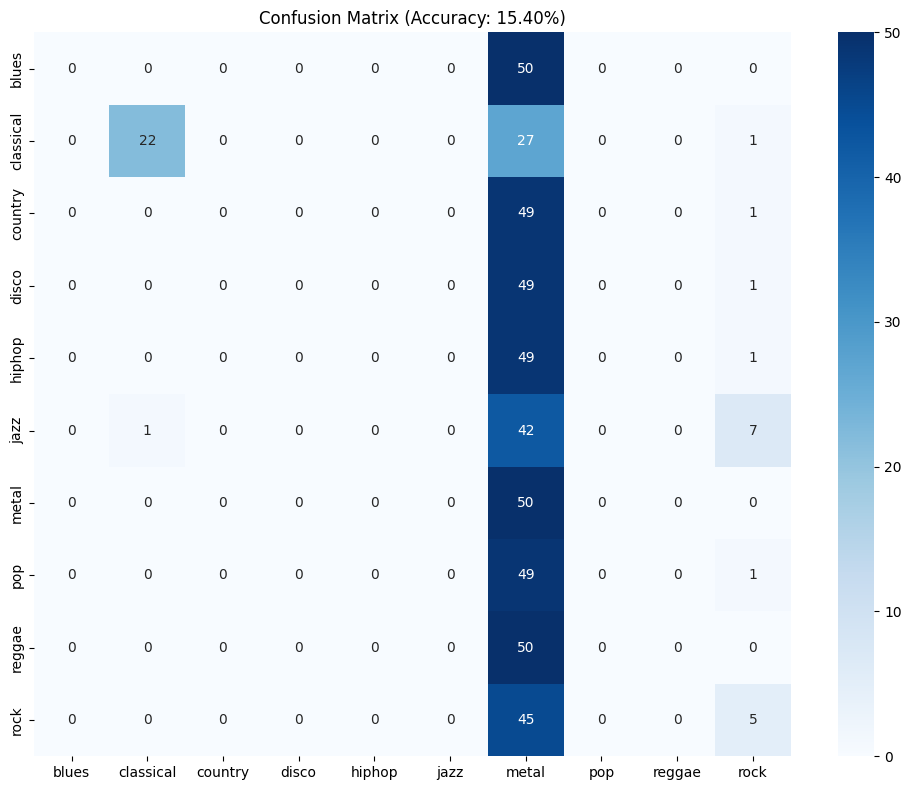

In [ ]:
# Plot curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss'); ax1.legend(); ax1.grid(alpha=0.3)
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=GENRES, digits=3))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENRES, yticklabels=GENRES)
plt.title(f'Confusion Matrix (Accuracy: {acc:.2%})')
plt.tight_layout()
plt.show()